### About this demo

This demo shows the jets information of original root file generated from MadGraph5 (MG5). Note one should generate their own MG5 raw data by theirselves, and store the whole directory in path `./jet_dataset`.

The information is presenting in graphs, plotted with `matplotlib.pyplot` and `seaborn`. This demo contains the folling contents:
- Distribution of particles (anti-particles) of jets.
- Distribution of jets energy flow information $p_T$, $\eta$, $\phi$.
- Distribution of particles energy flow information $p_T$, $\eta$, $\phi$.
- Distribution of number of particles within each jet event, with different `subjet_radius` (the radius used for reclusterting particles using *anti-$k_T$* algorithm).

In [1]:
import awkward as ak
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import module_data

sns.set_theme()

In [2]:
channel_list = ["VzToZhToVevebb", "VzToQCD", "VzToTt"]
fatjet_list = [module_data.FatJetEvents(channel, use_hdf5=False) for channel in channel_list]

# DataLog: Successfully create VzToZhToVevebb with 246300 events.
# DataLog: Successfully create VzToQCD with 241467 events.
# DataLog: Successfully create VzToTt with 239866 events.


### Distribution of different particles within each jet event

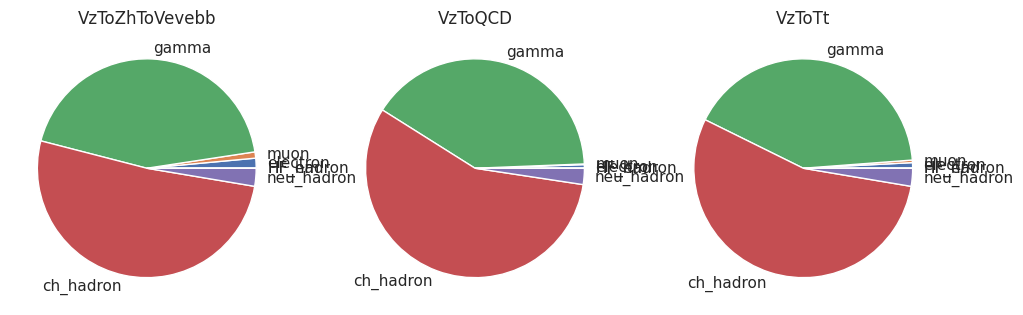

In [3]:
# Figure configurations.
num_row = 1 # Number of rows.
num_col = len(channel_list) # Number of columns.
width, height = 4 * num_col, 8 # Figure width and height.
facecolor = "white" # Figure background color

# Create figures.
fig, ax = plt.subplots(num_row, num_col, figsize=(width, height), facecolor=facecolor)

# Get table of article's pdg ID.
pdgid_table = module_data.pdgid_table
pdgid_keys = pdgid_table.keys()

def draw_pdgid_distribution(single_ax: plt.Axes , events: ak.Array):
    """Create particle pdgid distribution with pie charts.
    
    Negative pdgid values represent anti-particles, but we count them as same
    type by using the absolute value.

    Args:
        single_ax : Axes object
            One of the axes objects (usually ax[i] if have many axes).
        events : ak.Array
            Can be retrieved from `FatJetEvents.events`.
    """

    pdgid = events[f"fatjet_daughter_pid"]
    pdgid_counts = [
        ak.sum(np.abs(pdgid) == pdgid_table[key]) for key in pdgid_keys
    ]
    single_ax.pie(x=pdgid_counts, labels=pdgid_keys)

for i in range(len(channel_list)):
    channel = channel_list[i]
    draw_pdgid_distribution(single_ax=ax[i], events=fatjet_list[i].events)
    ax[i].set_title(channel)

### Distribution of jet (fatjet) $p_T$, $\eta$, $\phi$

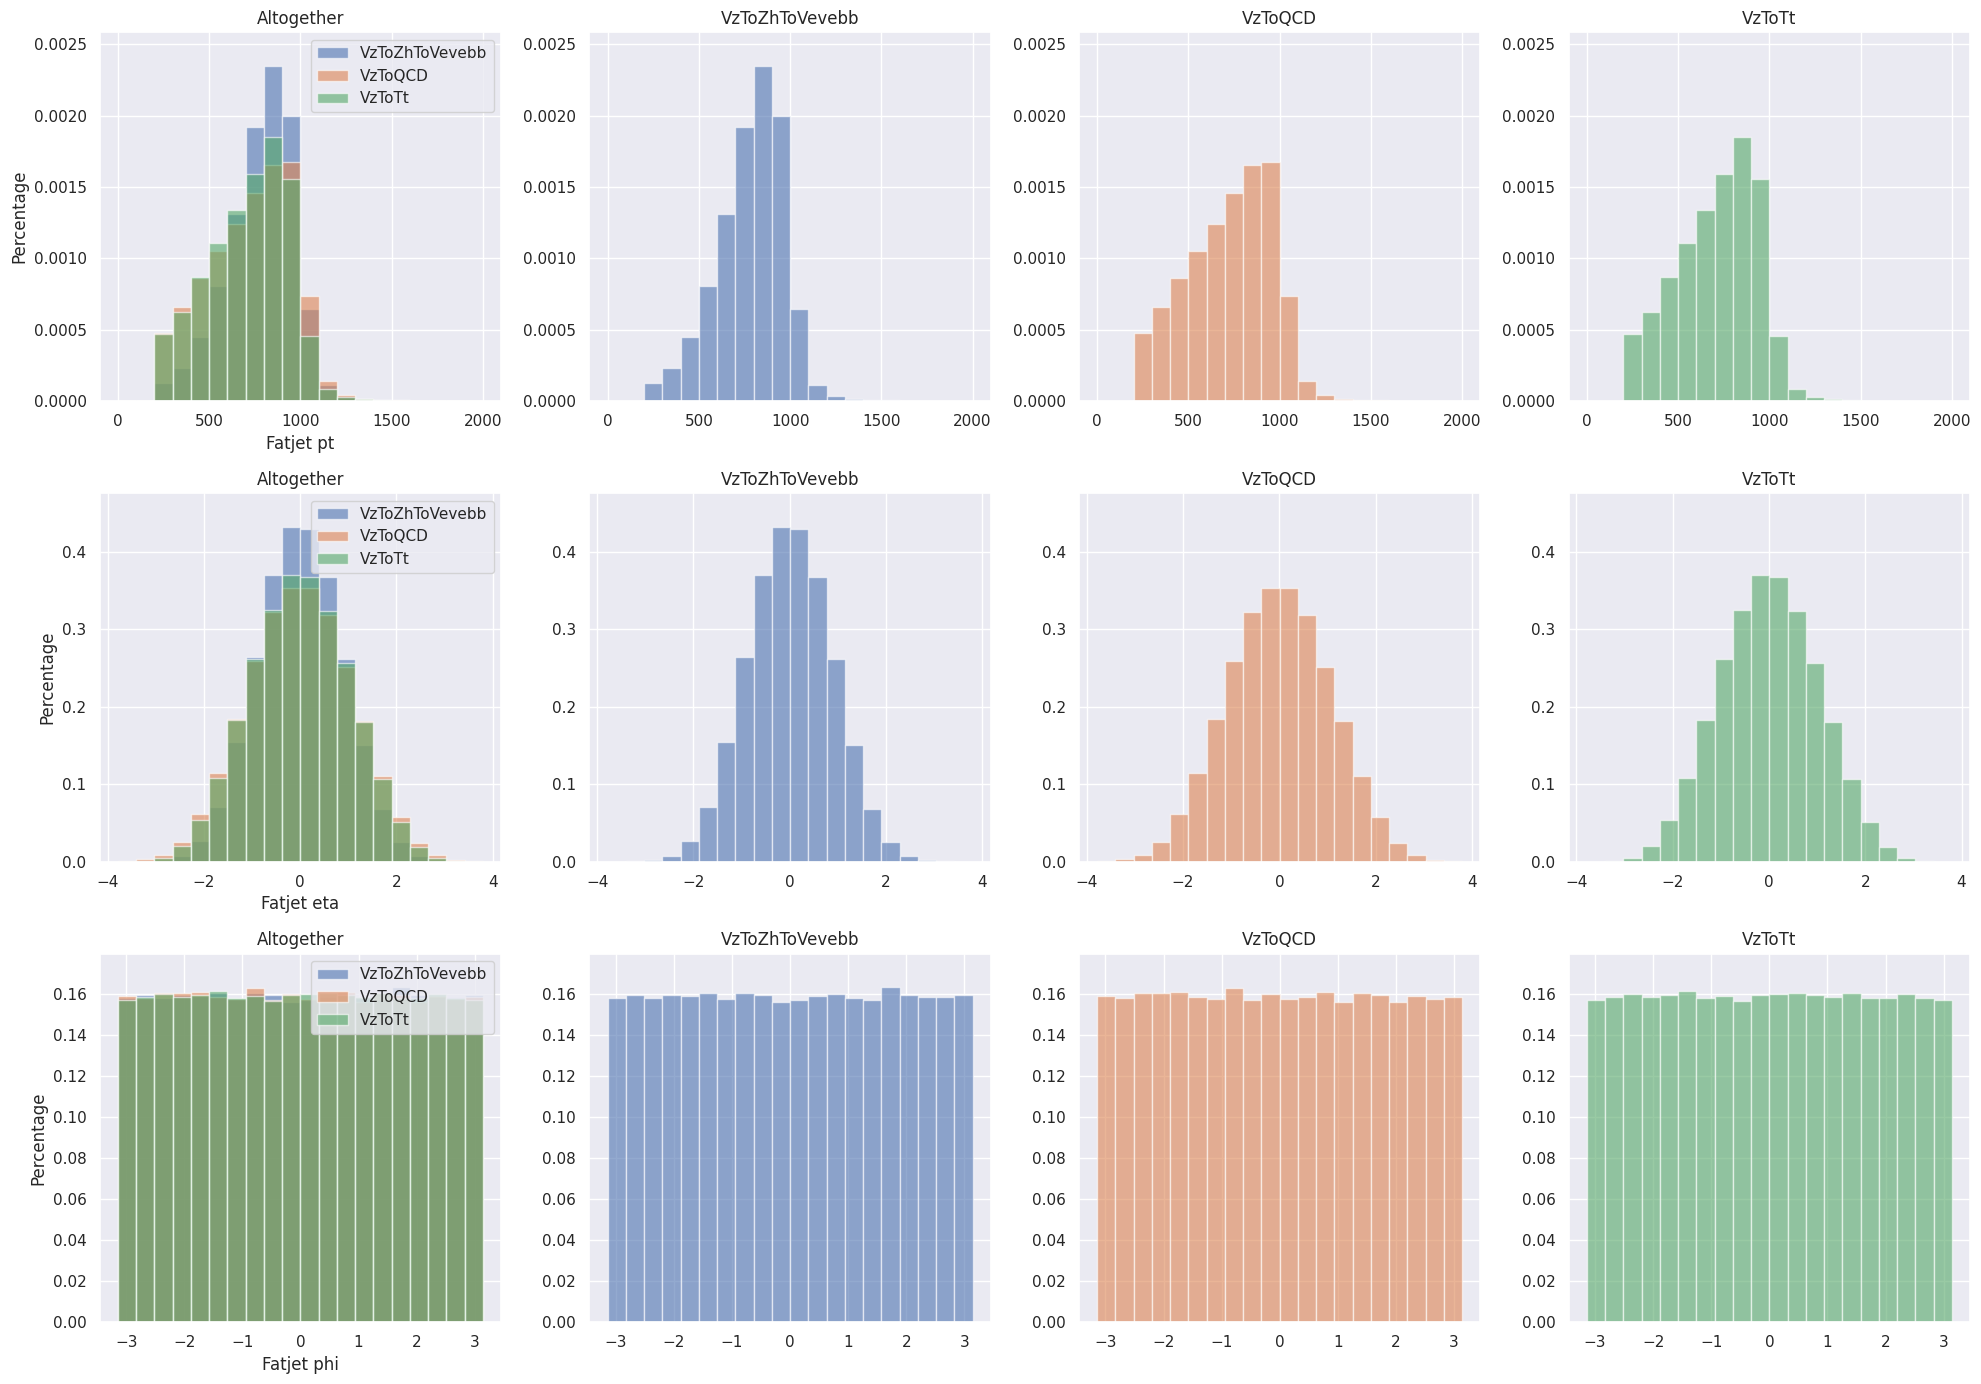

In [4]:
# Figure configurations.
num_row = 3 # Number of rows.
num_col = len(channel_list) + 1 # Number of columns, "+1" used for total.
width, height = 4 * (num_col + 1), 14 # Figure width and height.

# Create figures.
fig, ax = plt.subplots(num_row, num_col, figsize=(width, height))

def draw_jet_eflow_distribution(
        row_ax,
        feature: str,
        bins: int,
        xrange: tuple[int, int] = None
    ):
    """Draw distribution of jet energy flow information.
    
    Args:
        row_ax : Axes object
            One of the row of 2D axes object.
        feature : str
            The feature of jet to be drawed (pt, eta, or phi).
        bins : int
            Number of bins of the histogram.
        xrange : tuple[int, int]
            Tuple for the range of x-axis.
    """
    
    # Get `ak.Array` type events for each channel.
    events_list = [fatjet.events for fatjet in fatjet_list]

    # Determine the range for x-axis.
    if xrange is None:
        min_list = [ak.min(events[f"fatjet_{feature}"]) for events in events_list]
        max_list = [ak.max(events[f"fatjet_{feature}"]) for events in events_list]
        xrange = [min(min_list), max(max_list)]
    
    # Will determine the range for y-axis depending on the feature values.
    yrange = [0,0]
    
    for i in range(len(channel_list)):
        # One of the channel events.
        events = events_list[i]

        # Color for this channel.
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i]

        # `plt` needs to convert `ak.Array` to `np.array`
        data = ak.to_numpy(events[f"fatjet_{feature}"])

        # The 0-th column plots the total overlapped histogram.
        pdf, _, _ = row_ax[0].hist(
            x=data,
            bins=bins,
            label=channel_list[i],
            range=xrange,
            alpha=0.6,
            density=True
        )

        # The (i+1)-th column plots the individual histogram.
        row_ax[i+1].hist(
            x=data,
            bins=bins,
            label=channel_list[i],
            range=xrange,
            alpha=0.6,
            density=True,
            color=color
        )

        # Update the values for y_range such that the scale for each channel is
        # the same.
        yrange[1] = max(yrange[1], max(pdf))
    
    # Rescale the `yrange` value a bit more higher.
    yrange[1] *= 1.1

    for i in range(len(channel_list)):
        # Altogether column.
        row_ax[0].set_title(f"Altogether")
        row_ax[0].set_xlabel(f"Fatjet {feature}")
        row_ax[0].set_ylabel(f"Percentage")
        row_ax[0].set_ylim(yrange)
        row_ax[0].legend()
        
        # Individual column.
        row_ax[i+1].set_title(channel_list[i])
        row_ax[i+1].set_ylim(yrange)

# Draw distribution.
draw_jet_eflow_distribution(ax[0], "pt", bins=20, xrange=[0, 2000])
draw_jet_eflow_distribution(ax[1], "eta", bins=20)
draw_jet_eflow_distribution(ax[2], "phi", bins=20)
plt.tight_layout()

### Distribution of jet (fatjet) daughter particle information

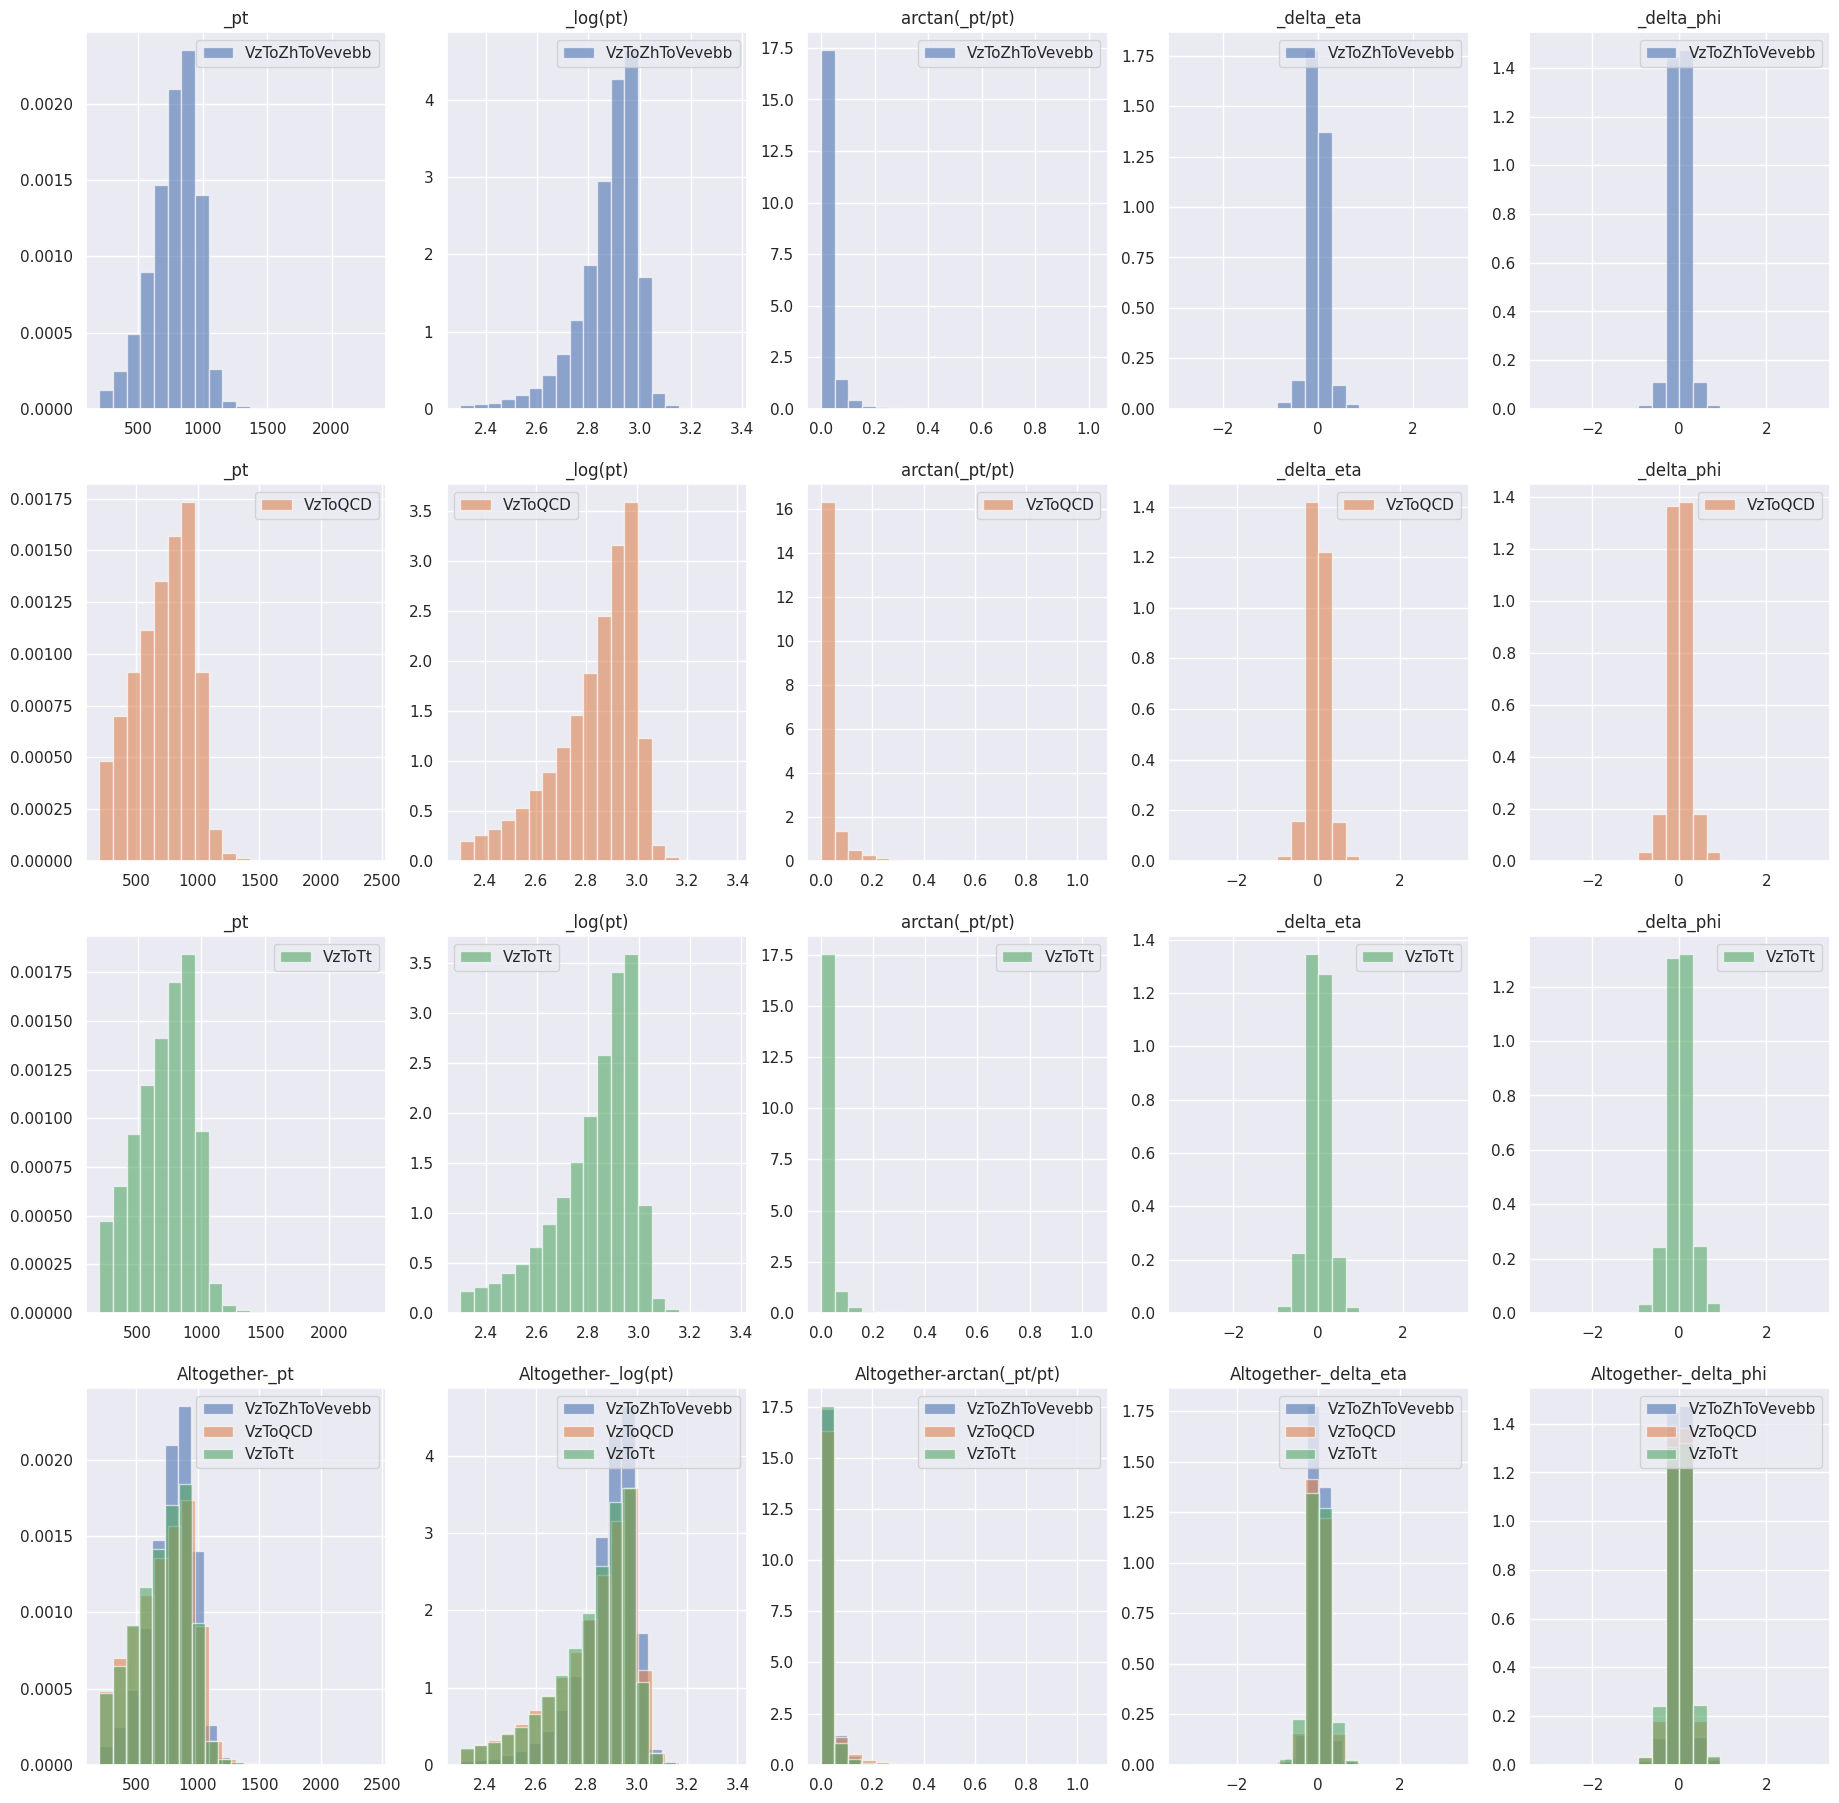

In [5]:
def draw_feature_hist(ax: plt.Axes, x: np.array, channel: str, color_idx: int):
    """Draw histogram of a particlue feature array (x)."""

    # Choose the same color for same row.
    color=plt.rcParams['axes.prop_cycle'].by_key()['color'][color_idx]

    # Plot histogram.
    ax.hist(
        x=x,
        bins=20,
        label=channel,
        range=None,
        alpha=0.6,
        density=True,
        color=color,
    )

def get_raveled_events(events: module_data.FatJetEvents):
    """Return raveled feature ak.Array dictionary."""
    
    jet_pt = events.events["fatjet_pt"]
    daughter_pt = events.events["fast_pt"]
    delta_eta = events.events["fast_delta_eta"]
    delta_phi = events.events["fast_delta_phi"]

    return {
        "_pt": ak.ravel(jet_pt),
        "_log(pt)": ak.ravel(np.log10(jet_pt)),
        "arctan(_pt/pt)": ak.ravel(daughter_pt / jet_pt),
        "_delta_eta": ak.ravel(delta_eta),
        "_delta_phi": ak.ravel(delta_phi),
    }

# Create raveled events for each fatjet event.
raveled_events_list = [get_raveled_events(fatjet) for fatjet in fatjet_list]

# Get feature keys of raveled events.
feature_keys = list(raveled_events_list[0].keys())

# Figure configurations.
num_row = len(channel_list) + 1 # Number of rows.
num_col = len(feature_keys) # Number of columns.
width = 4.5 * num_col # Figure width.
height = 4.5 * (num_row + 1) # Figure height.

# Create figures.
fig, ax = plt.subplots(num_row, num_col, figsize=(width, height))

for feature_idx in range(len(feature_keys)):
    feature = feature_keys[feature_idx]
    
    for channel_idx in range(len(channel_list)):
        feature_array = raveled_events_list[channel_idx][feature]
        feature_array = np.array(feature_array)

        # Individual figure for each channel.
        individual_ax = ax[channel_idx][feature_idx]
        draw_feature_hist(
            ax=individual_ax, 
            x=feature_array,
            channel=channel_list[channel_idx],
            color_idx=channel_idx
        )
        individual_ax.set_title(f"{feature}")
        individual_ax.legend()

        # Altogether in a figure.
        altogether_ax = ax[num_row-1][feature_idx]
        draw_feature_hist(
            ax=altogether_ax, 
            x=feature_array,
            channel=channel_list[channel_idx],
            color_idx=channel_idx
        )
        altogether_ax.set_title(f"Altogether-{feature}")
        altogether_ax.legend()